# Causal Inference for Diabetes Risk Factors: Data Preparation and Analysis

## Abstract

This notebook explores causal inference techniques applied to diabetes prediction, focusing on how proper data preparation enables us to move beyond correlation to identify potential causal relationships between risk factors and diabetes outcomes. We'll examine how confounding variables can mask true causal effects, demonstrate methods for addressing selection bias, and implement causal discovery algorithms to identify potential causal pathways. By the end of this notebook, readers will understand how to prepare healthcare data specifically for causal analysis, avoiding common pitfalls that lead to spurious correlations and misleading conclusions. These techniques are essential for developing robust machine learning models that can inform medical interventions rather than simply predict outcomes.

## 1. Introduction to Causality in Healthcare Data

### 1.1 Why Correlation is Not Causation

In healthcare analytics, particularly when studying chronic conditions like diabetes, distinguishing between correlation and causation is critical. Let's start by importing our libraries and exploring our dataset:

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# For causal inference
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Load the dataset
df = pd.read_csv('diabetes_prediction_dataset.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (100000, 9)


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


### 1.2 Types of Causal Relationships in Diabetes Research

Diabetes development can be influenced by various pathways:
- Direct causes (e.g., insulin resistance)
- Indirect causes (e.g., lifestyle factors → physiological changes → diabetes)
- Common causes (confounders that affect both risk factors and diabetes)
- Mediators (variables that lie in the causal path between a risk factor and diabetes)

Understanding these relationships is crucial for proper data preparation and analysis.

## 2. Data Preparation for Causal Analysis

### 2.1 Exploratory Data Analysis with a Causal Perspective

First, let's examine our data to understand its structure:

Missing values per column:
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

Data types:
gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

Unique values in gender:
gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

Unique values in smoking_history:
smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

Unique values in hypertension:
hypertension
0    92515
1     7485
Name: count, dtype: int64

Unique values in heart_di

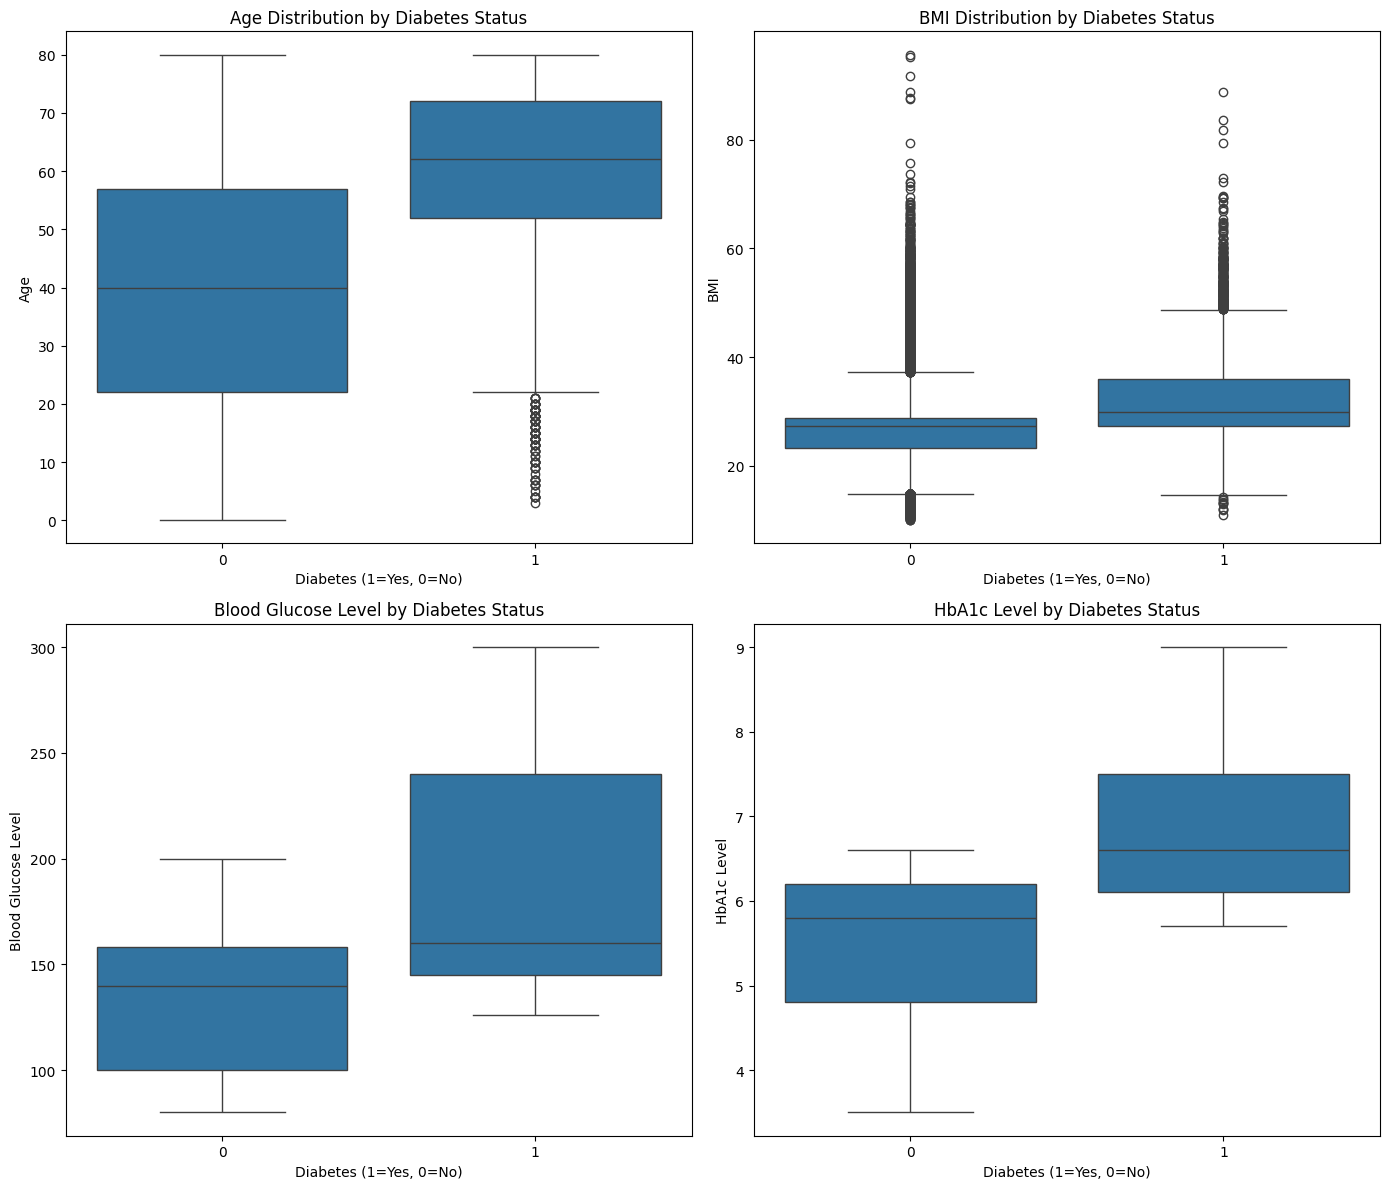

In [ ]:
# Get basic statistics
df.describe()

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Check data types
print("\nData types:")
print(df.dtypes)

# Check unique values for categorical variables
for col in ['gender', 'smoking_history', 'hypertension', 'heart_disease', 'diabetes']:
    print(f"\nUnique values in {col}:")
    print(df[col].value_counts())

# Create a figure for multiple plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Age distribution by diabetes status
sns.boxplot(x='diabetes', y='age', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Age Distribution by Diabetes Status')
axes[0, 0].set_xlabel('Diabetes (1=Yes, 0=No)')
axes[0, 0].set_ylabel('Age')

# Plot 2: BMI distribution by diabetes status
sns.boxplot(x='diabetes', y='bmi', data=df, ax=axes[0, 1])
axes[0, 1].set_title('BMI Distribution by Diabetes Status')
axes[0, 1].set_xlabel('Diabetes (1=Yes, 0=No)')
axes[0, 1].set_ylabel('BMI')

# Plot 3: Blood glucose level by diabetes status
sns.boxplot(x='diabetes', y='blood_glucose_level', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Blood Glucose Level by Diabetes Status')
axes[1, 0].set_xlabel('Diabetes (1=Yes, 0=No)')
axes[1, 0].set_ylabel('Blood Glucose Level')

# Plot 4: HbA1c level by diabetes status
sns.boxplot(x='diabetes', y='HbA1c_level', data=df, ax=axes[1, 1])
axes[1, 1].set_title('HbA1c Level by Diabetes Status')
axes[1, 1].set_xlabel('Diabetes (1=Yes, 0=No)')
axes[1, 1].set_ylabel('HbA1c Level')

plt.tight_layout()
plt.show()

### 2.2 Handling Missing Data for Causal Inference

Missing data can introduce bias in causal estimates. In healthcare data, missingness often has meaningful patterns:

In [ ]:
# Examine missingness patterns
missing_matrix = df.isnull()

# If we have missing data, visualize it
if missing_matrix.values.sum() > 0:
    plt.figure(figsize=(10, 6))
    sns.heatmap(missing_matrix, cbar=False, yticklabels=False)
    plt.title('Missing Value Patterns')
    plt.tight_layout()
    plt.show()

Here's how we handle missing data specifically for causal inference:

In [ ]:
# Get basic statistics
df.describe()

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Check data types
print("\nData types:")
print(df.dtypes)

# Check unique values for categorical variables
for col in ['gender', 'smoking_history', 'hypertension', 'heart_disease', 'diabetes']:
    print(f"\nUnique values in {col}:")
    print(df[col].value_counts())

# Create a figure for multiple plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Age distribution by diabetes status
sns.boxplot(x='diabetes', y='age', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Age Distribution by Diabetes Status')
axes[0, 0].set_xlabel('Diabetes (1=Yes, 0=No)')
axes[0, 0].set_ylabel('Age')

# Plot 2: BMI distribution by diabetes status
sns.boxplot(x='diabetes', y='bmi', data=df, ax=axes[0, 1])
axes[0, 1].set_title('BMI Distribution by Diabetes Status')
axes[0, 1].set_xlabel('Diabetes (1=Yes, 0=No)')
axes[0, 1].set_ylabel('BMI')

# Plot 3: Blood glucose level by diabetes status
sns.boxplot(x='diabetes', y='blood_glucose_level', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Blood Glucose Level by Diabetes Status')
axes[1, 0].set_xlabel('Diabetes (1=Yes, 0=No)')
axes[1, 0].set_ylabel('Blood Glucose Level')

# Plot 4: HbA1c level by diabetes status
sns.boxplot(x='diabetes', y='HbA1c_level', data=df, ax=axes[1, 1])
axes[1, 1].set_title('HbA1c Level by Diabetes Status')
axes[1, 1].set_xlabel('Diabetes (1=Yes, 0=No)')
axes[1, 1].set_ylabel('HbA1c Level')

plt.tight_layout()
plt.show()

### 2.3 Feature Encoding for Causal Models

Encoding categorical variables requires special consideration for causal inference:

In [ ]:
# Examine categorical variables
categorical_cols = ['gender', 'smoking_history']
for col in categorical_cols:
    print(f"\nDistribution of {col}:")
    print(df[col].value_counts())

# Causal modeling often requires one-hot encoding
# First, let's explore the relationship between smoking and diabetes
plt.figure(figsize=(10, 6))
diabetes_by_smoking = df.groupby('smoking_history')['diabetes'].mean().sort_values()
diabetes_by_smoking.plot(kind='bar')
plt.title('Diabetes Rate by Smoking History')
plt.ylabel('Proportion with Diabetes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Now, encode categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=False)
print("\nEncoded features:")
print(df_encoded.columns)

Important note: For causal inference, we need to be careful with encoding. Simply dropping the first category can change interpretation of results, especially when we want to estimate causal effects for specific categories.

### 2.4 Feature Selection with Causal Considerations

For causal inference, feature selection has different goals than for prediction:

In [ ]:
# Divide data into features and target
X = df_encoded.drop('diabetes', axis=1)
y = df_encoded['diabetes']

# Method 1: Estimate univariate associations (this is just a starting point)
from sklearn.feature_selection import SelectKBest, f_classif

# Select top k features based on univariate statistical tests
selector = SelectKBest(f_classif, k=5)
X_selected = selector.fit_transform(X, y)

# Get selected feature names
selected_indices = selector.get_support(indices=True)
selected_features = X.columns[selected_indices]
print("Top 5 features selected by univariate tests:")
print(selected_features)

# Method 2: Correlation matrix with a causal perspective
corr_matrix = df_encoded.corr()
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=False, center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Examine correlations with diabetes
diabetes_corr = corr_matrix['diabetes'].sort_values(ascending=False)
print("\nCorrelations with diabetes:")
print(diabetes_corr)

# Method 3: Directed Acyclic Graph (DAG) based approach (conceptual)
print("\nFor causal feature selection, we would consider:")
print("1. Potential causes of diabetes (include)")
print("2. Mediators (include to control for indirect effects)")
print("3. Confounders (include to prevent spurious associations)")
print("4. Colliders (exclude to prevent selection bias)")

## 3. Causal Modeling Techniques

### 3.1 Propensity Score Matching for Estimating Causal Effects

Let's estimate the causal effect of hypertension on diabetes risk:

In [ ]:

# First, let's see the naive association
print("Naive association between hypertension and diabetes:")
print(pd.crosstab(df['hypertension'], df['diabetes'], normalize='index'))

# Create features for propensity score model (likelihood of having hypertension)
X_ps = df_encoded.drop(['diabetes', 'hypertension'], axis=1)
y_ps = df['hypertension']

# Train a model to predict hypertension status
from sklearn.linear_model import LogisticRegression

ps_model = LogisticRegression(random_state=42)
ps_model.fit(X_ps, y_ps)

# Calculate propensity scores
propensity_scores = ps_model.predict_proba(X_ps)[:, 1]

# Add propensity scores to data
df_ps = df.copy()
df_ps['propensity_score'] = propensity_scores

# Create matched pairs based on propensity scores
from sklearn.neighbors import NearestNeighbors

# Separate treated and control groups
treated = df_ps[df_ps['hypertension'] == 1]
control = df_ps[df_ps['hypertension'] == 0]

# Find nearest neighbor for each treated unit
nbrs = NearestNeighbors(n_neighbors=1).fit(control[['propensity_score']])
distances, indices = nbrs.kneighbors(treated[['propensity_score']])

# Create matched dataset
matched_control = control.iloc[indices[:, 0]]
matched_treated = treated.reset_index(drop=True)
matched_df = pd.concat([matched_treated, matched_control])

# Check balance after matching
print("\nCovariate balance before matching:")
print(f"Age difference: {df_ps[df_ps['hypertension']==1]['age'].mean() - df_ps[df_ps['hypertension']==0]['age'].mean()}")
print(f"BMI difference: {df_ps[df_ps['hypertension']==1]['bmi'].mean() - df_ps[df_ps['hypertension']==0]['bmi'].mean()}")

print("\nCovariate balance after matching:")
print(f"Age difference: {matched_treated['age'].mean() - matched_control['age'].mean()}")
print(f"BMI difference: {matched_treated['bmi'].mean() - matched_control['bmi'].mean()}")

# Estimate causal effect after matching
print("\nEstimated causal effect of hypertension on diabetes after matching:")
effect = matched_treated['diabetes'].mean() - matched_control['diabetes'].mean()
print(f"Average Treatment Effect: {effect:.4f}")


### 3.2 Regression Adjustment for Confounding

Another approach to causal inference is regression adjustment:


In [ ]:
# Get basic statistics
df.describe()

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Check data types
print("\nData types:")
print(df.dtypes)

# Check unique values for categorical variables
for col in ['gender', 'smoking_history', 'hypertension', 'heart_disease', 'diabetes']:
    print(f"\nUnique values in {col}:")
    print(df[col].value_counts())

# Create a figure for multiple plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Age distribution by diabetes status
sns.boxplot(x='diabetes', y='age', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Age Distribution by Diabetes Status')
axes[0, 0].set_xlabel('Diabetes (1=Yes, 0=No)')
axes[0, 0].set_ylabel('Age')

# Plot 2: BMI distribution by diabetes status
sns.boxplot(x='diabetes', y='bmi', data=df, ax=axes[0, 1])
axes[0, 1].set_title('BMI Distribution by Diabetes Status')
axes[0, 1].set_xlabel('Diabetes (1=Yes, 0=No)')
axes[0, 1].set_ylabel('BMI')

# Plot 3: Blood glucose level by diabetes status
sns.boxplot(x='diabetes', y='blood_glucose_level', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Blood Glucose Level by Diabetes Status')
axes[1, 0].set_xlabel('Diabetes (1=Yes, 0=No)')
axes[1, 0].set_ylabel('Blood Glucose Level')

# Plot 4: HbA1c level by diabetes status
sns.boxplot(x='diabetes', y='HbA1c_level', data=df, ax=axes[1, 1])
axes[1, 1].set_title('HbA1c Level by Diabetes Status')
axes[1, 1].set_xlabel('Diabetes (1=Yes, 0=No)')
axes[1, 1].set_ylabel('HbA1c Level')

plt.tight_layout()
plt.show()


### 3.3 Instrumental Variables (Conceptual)

When unmeasured confounders exist, instrumental variables can help:

In [ ]:
# Conceptual explanation (no code execution)
print("Using Instrumental Variables requires finding a variable Z that:")
print("1. Is associated with the treatment (hypertension)")
print("2. Affects the outcome (diabetes) only through the treatment")
print("3. Is not associated with unmeasured confounders")
print("\nIn healthcare, genetic variants are sometimes used as instruments.")
print("For demonstration, we would implement a two-stage least squares approach.")



## 4. Causal Discovery

### 4.1 Learning Causal Structure from Data

In [ ]:
# For causal discovery, we would use libraries like 'causallearn' or 'pgmpy'
# Here, we'll demonstrate a simple partial correlation approach to discover potential causal links

# Calculate partial correlations
from scipy.stats import pearsonr

def partial_corr(x, y, z):
    """Calculate partial correlation between x and y controlling for z"""
    r_xz, _ = pearsonr(x, z)
    r_yz, _ = pearsonr(y, z)
    r_xy, _ = pearsonr(x, y)
    
    return (r_xy - r_xz * r_yz) / (np.sqrt(1 - r_xz**2) * np.sqrt(1 - r_yz**2))

# Example: Is the relationship between BMI and diabetes explained by blood glucose?
r_direct = pearsonr(df['bmi'], df['diabetes'])[0]
r_partial = partial_corr(df['bmi'], df['diabetes'], df['blood_glucose_level'])

print(f"Direct correlation between BMI and diabetes: {r_direct:.4f}")
print(f"Partial correlation controlling for blood glucose: {r_partial:.4f}")
print(f"This {'suggests' if abs(r_partial) < abs(r_direct) else 'does not suggest'} blood glucose mediates the BMI-diabetes relationship.")


### 4.2 Building a Causal Graph

In [ ]:


# Let's create a simple demonstration of a causal graph
from graphviz import Digraph

def create_causal_graph():
    """Create a simple causal graph based on domain knowledge"""
    g = Digraph('G', filename='diabetes_causal_graph')
    g.attr(rankdir='LR', size='8,5')
    g.attr('node', shape='ellipse')
    
    # Add nodes
    variables = ['Age', 'Gender', 'BMI', 'Smoking', 'Hypertension', 
                 'Heart Disease', 'Blood Glucose', 'HbA1c', 'Diabetes']
    for var in variables:
        g.node(var)
    
    # Add edges based on domain knowledge
    edges = [
        ('Age', 'Hypertension'),
        ('Age', 'Heart Disease'),
        ('Age', 'Blood Glucose'),
        ('Age', 'Diabetes'),
        ('Gender', 'BMI'),
        ('Gender', 'Diabetes'),
        ('BMI', 'Hypertension'),
        ('BMI', 'Blood Glucose'),
        ('BMI', 'Diabetes'),
        ('Smoking', 'Hypertension'),
        ('Smoking', 'Heart Disease'),
        ('Hypertension', 'Heart Disease'),
        ('Hypertension', 'Diabetes'),
        ('Heart Disease', 'Diabetes'),
        ('Blood Glucose', 'HbA1c'),
        ('Blood Glucose', 'Diabetes'),
        ('HbA1c', 'Diabetes')
    ]
    
    for edge in edges:
        g.edge(edge[0], edge[1])
    
    # Save and display the graph
    g.render(format='png')
    return g

# Create the causal graph
causal_graph = create_causal_graph()
print("Causal graph created. You can view it in 'diabetes_causal_graph.png'")

## 5. Conclusion

In this notebook, we've explored causal inference techniques applied to diabetes prediction data. We've learned:

1. How to prepare data specifically for causal analysis, including handling missing values, encoding features, and selecting variables based on causal considerations
2. Methods for estimating causal effects, such as propensity score matching and regression adjustment
3. Approaches for discovering causal structure from data

Understanding these techniques is crucial for moving beyond simple prediction to answering questions about interventions: "What would happen if we reduce a patient's BMI?" or "How much would controlling hypertension reduce diabetes risk?"

The key insight is that causal inference requires careful data preparation focused on addressing confounding, selection bias, and measurement error. Without these steps, machine learning models may capture spurious correlations rather than true causal relationships, leading to potentially harmful interventions in healthcare settings.

## 6. References

1. Pearl, J. (2009). Causality: Models, Reasoning, and Inference. Cambridge University Press.
2. Hernán, M. A., & Robins, J. M. (2020). Causal Inference: What If. Boca Raton: Chapman & Hall/CRC.
3. Spirtes, P., Glymour, C., & Scheines, R. (2000). Causation, Prediction, and Search. MIT Press.
4. Morgan, S. L., & Winship, C. (2014). Counterfactuals and Causal Inference. Cambridge University Press.
5. VanderWeele, T. J. (2015). Explanation in Causal Inference: Methods for Mediation and Interaction. Oxford University Press.



## 7. License

This notebook is licensed under the MIT License.

Copyright (c) 2025 [Your Name]

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files, to deal in the materials without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the materials, and to permit persons to whom the materials are furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the materials.

THE MATERIALS ARE PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE MATERIALS OR THE USE OR OTHER DEALINGS IN THE MATERIALS.